# Progetto DS Lab - Matteo Campironi, Serena Di Maggio

---

# 0. Change directories

Modificare le directory dei file `list.xlsx` e `output.jsonl` per la corretta esecuzione del codice.

In [1]:
df_list = 'list.xlsx'
output_SPECTER = 'output.jsonl'

# 1. Data preparation

In [2]:
import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

Carico il dataset e seleziono solo le colonne necessarie:

In [3]:
df = pd.read_excel(df_list)
df = df[['ID prodotto','Abstract','Abstract inglese','Abstract francese','Abstract tedesco','Abstract spagnolo','Abstract italiano',"parole chiave scelte dall'utente (concatenazione)",'Titolo', 'Anno di pubblicazione', 'Tutti gli autori/Curatori', 'contributors: Autori/curatori attualmente afferenti (elenco)', 'rivista: denominazione', 'Tipologia (collezione)']]

Seleziono solo gli articoli su rivista:

In [4]:
df['Tipologia (collezione)'].unique()

array(['01 - Articolo su rivista', '04 - Monografia',
       '03 - Contributo in libro', '05 - Curatele', '99 - Altro',
       '02 - Intervento a convegno', '09 - Tesi di dottorato',
       '07 - Tesi di dottorato Bicocca post 2009'], dtype=object)

In [5]:
df = df[df['Tipologia (collezione)'] == '01 - Articolo su rivista']
df = df.drop(columns='Tipologia (collezione)')
df

,ID prodotto,Abstract,Abstract inglese,Abstract francese,Abstract tedesco,Abstract spagnolo,Abstract italiano,parole chiave scelte dall'utente (concatenazione),Titolo,Anno di pubblicazione,Tutti gli autori/Curatori,contributors: Autori/curatori attualmente afferenti (elenco),rivista: denominazione
0,235,"We consider a Cournot oligopoly game, where fi...",NaN,NaN,NaN,NaN,NaN,ECONOMIA POLITICA,Oligopoly games with nonlinear demand and cost...,2006,"Naimzada, AK; Sbragia, L","NAIMZADA, AHMAD KABIR","CHAOS, SOLITONS AND FRACTALS"
1,340,This paper investigates the investment behavio...,NaN,NaN,NaN,NaN,NaN,COMPORTAMENTO ECONOMICO; ECONOMIC BEHAVIOR; RA...,Investment decisions and the soft budget const...,2006,"Colombo, E; Stanca, LM","COLOMBO, EMILIO; STANCA, LUCA MATTEO",ECONOMICS OF TRANSITION
2,340,This paper investigates the investment behavio...,NaN,NaN,NaN,NaN,NaN,COMPORTAMENTO ECONOMICO; ECONOMIC BEHAVIOR; RA...,Investment decisions and the soft budget const...,2006,"Colombo, E; Stanca, LM","COLOMBO, EMILIO; STANCA, LUCA MATTEO",ECONOMICS OF TRANSITION
3,423,NaN,In this paper we investigate heavy crude oil a...,NaN,NaN,NaN,NaN,APPLIED ECONOMETRICS; ECONOMETRIA APPLICATA; E...,Modeling and forecasting cointegrated relation...,2005,"Lanza, A; Manera, M; Giovannini, M","MANERA, MATTEO",ENERGY ECONOMICS
4,538,We propose an oligopoly game where quantity se...,NaN,NaN,NaN,NaN,NaN,ECONOMIA POLITICA,Oligopoly games with local monopolistic approx...,2007,"Bischi, GI; Naimzada, AK; Sbragia, L","NAIMZADA, AHMAD KABIR",JOURNAL OF ECONOMIC BEHAVIOR & ORGANIZATION
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3839,273076,NaN,Radon is a noble gas that occurs in nature as ...,NaN,NaN,NaN,NaN,STATISTICA; STATISTICS,Analysing radon accumulation in the home by fl...,2019,"Borgoni, R; Carcagnì, A; Salvati, N; Schmid, T","Borgoni, R; Carcagnì, A",STOCHASTIC ENVIRONMENTAL RESEARCH AND RISK ASS...
3840,273076,NaN,Radon is a noble gas that occurs in nature as ...,NaN,NaN,NaN,NaN,NaN,Analysing radon accumulation in the home by fl...,2019,"Borgoni, R; Carcagnì, A; Salvati, N; Schmid, T","Borgoni, R; Carcagnì, A",STOCHASTIC ENVIRONMENTAL RESEARCH AND RISK ASS...
3842,273099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scorte cerealicole e panificazione nelle forte...,2019,"Ongaro, G",Giulio Ongaro,STUDI STORICI LUIGI SIMEONI
3843,273390,NaN,The empirical literature on electricity market...,NaN,NaN,NaN,NaN,CROSS-BORDER TRADE OF ELECTRICITY; POWER EXCHA...,The RES-Induced Switching Effect Across Fossil...,2019,"Gianfreda, A; Parisio, L; Pelagatti, M","Parisio, L; Pelagatti M",THE ENERGY JOURNAL


Come è possibile osservare, è necessario svolgere un lavoro di pulizia sulle colonne riguardante gli abstract. Esistono infatti dei record che non contengono alcun tipo di abstract, mentre alcuni si ripetono.

In [6]:
#elimino righe senza nessun tipo di abstract
df = df.dropna(subset=['Abstract','Abstract inglese','Abstract francese','Abstract tedesco','Abstract spagnolo','Abstract italiano'], how='all')

# elimino righe doppie
df = df.drop_duplicates(['ID prodotto','Abstract','Abstract inglese','Abstract francese','Abstract tedesco','Abstract spagnolo','Abstract italiano'], keep='first')

Per come è strutturato il dataset, se non viene selezionata la lingua dell'abstract durante il caricamento sui sistemi informativi allora questo finirà sotto la generica categoria `Abstract`. 

Dal momento che la lingua inglese è la più utilizzata per gli articoli scientifici, verrà costruita una nuova colonna contenente i valori presi da `Abstract` quando `Abstract inglese` presenta un valore nullo:

In [7]:
df['finalAbstract'] = np.where(df['Abstract inglese'].isna(), df['Abstract'], df['Abstract inglese'])

#elimino eventuali NaN dovuti ad abstract scritti in altre lingue
df = df.dropna(subset=['finalAbstract'])

Vengono quindi eliminate le colonne non necessarie ed eventuali abstract duplicati:

In [8]:
df = df[['ID prodotto', 'finalAbstract', "parole chiave scelte dall'utente (concatenazione)",'Titolo', 'Anno di pubblicazione', 'Tutti gli autori/Curatori', 'contributors: Autori/curatori attualmente afferenti (elenco)', 'rivista: denominazione']]
df = df.drop_duplicates('finalAbstract', keep='first')
df

,ID prodotto,finalAbstract,parole chiave scelte dall'utente (concatenazione),Titolo,Anno di pubblicazione,Tutti gli autori/Curatori,contributors: Autori/curatori attualmente afferenti (elenco),rivista: denominazione
0,235,"We consider a Cournot oligopoly game, where fi...",ECONOMIA POLITICA,Oligopoly games with nonlinear demand and cost...,2006,"Naimzada, AK; Sbragia, L","NAIMZADA, AHMAD KABIR","CHAOS, SOLITONS AND FRACTALS"
1,340,This paper investigates the investment behavio...,COMPORTAMENTO ECONOMICO; ECONOMIC BEHAVIOR; RA...,Investment decisions and the soft budget const...,2006,"Colombo, E; Stanca, LM","COLOMBO, EMILIO; STANCA, LUCA MATTEO",ECONOMICS OF TRANSITION
3,423,In this paper we investigate heavy crude oil a...,APPLIED ECONOMETRICS; ECONOMETRIA APPLICATA; E...,Modeling and forecasting cointegrated relation...,2005,"Lanza, A; Manera, M; Giovannini, M","MANERA, MATTEO",ENERGY ECONOMICS
4,538,We propose an oligopoly game where quantity se...,ECONOMIA POLITICA,Oligopoly games with local monopolistic approx...,2007,"Bischi, GI; Naimzada, AK; Sbragia, L","NAIMZADA, AHMAD KABIR",JOURNAL OF ECONOMIC BEHAVIOR & ORGANIZATION
5,611,This paper re-examines the issue of asymmetrie...,APPLIED ECONOMETRICS; ECONOMETRIA APPLICATA; E...,Rockets and feathers revisited: an internation...,2003,"Galeotti, M; Lanza, A; Manera, M","MANERA, MATTEO",ENERGY ECONOMICS
...,...,...,...,...,...,...,...,...
3833,272697,We prove two results on the generic determinac...,TEORIE DEL VOTO; TEORIA DEI GIOCHI; POLITICAL ...,"On stable outcomes of approval, plurality, and...",2015,"De SInopoli, F; Iannantuoni, G; Pimienta, G","Iannantuoni, G",SOCIAL CHOICE AND WELFARE
3834,272700,We consider a model where policy motivated cit...,TEORIE DEL VOTO; TEORIA DEI GIOCHI; POLITICAL ...,Moderating Government,2015,"De Sinopoli, F; Ferraris, L; Iannantuoni, G","Iannantuoni, G",SOCIAL CHOICE AND WELFARE
3835,272840,This article addresses the issue of building r...,CAMPIONAMENTO; STATISTICA,Robustness against outliers: A new variance in...,2019,"Di Brisco, A; Migliorati, S; Ongaro, A","Di Brisco, AM; Migliorati, S; Ongaro, A",STATISTICAL MODELLING
3839,273076,Radon is a noble gas that occurs in nature as ...,STATISTICA; STATISTICS,Analysing radon accumulation in the home by fl...,2019,"Borgoni, R; Carcagnì, A; Salvati, N; Schmid, T","Borgoni, R; Carcagnì, A",STOCHASTIC ENVIRONMENTAL RESEARCH AND RISK ASS...


Come spiegato precedentemente, sulla colonna `Abstract` non viene effettuato alcun controllo sulla lingua di immissione. Di conseguenza è necesario verificare che la colonna `abstr` contenga solo testi in inglese:

In [9]:
from googletrans import Translator
translator = Translator()

In [10]:
#restituisce una stringa con lingua e relativa confidenza
df['lang/conf'] = [translator.detect(abstract) for abstract in df.finalAbstract]

#vengono separate lingua e confidenza in due colonne
df['conf'] = [conf.confidence for conf in df['lang/conf']]
df['lang'] = [language.lang for language in df['lang/conf']]

Se la confidenza è uguale a 1, allora si è certi che la libreria `Translator` abbia svolto il suo lavoro correttamente. Vengono invece verificati manualmente gli abstract con confidenza minore di 1 per controllare che non vengano erroneamente eliminati abstract in inglese:

In [11]:
df[(df['lang'] != 'en') & (df['conf'] < 1)]

,ID prodotto,finalAbstract,parole chiave scelte dall'utente (concatenazione),Titolo,Anno di pubblicazione,Tutti gli autori/Curatori,contributors: Autori/curatori attualmente afferenti (elenco),rivista: denominazione,lang/conf,conf,lang
609,8855,Cet article présente les caractéristiques et l...,ECONOMIC HISTORY; EUROPEAN INTEGRATION HISTORY...,Marché foncier et systèmes de production agric...,2008,"Tedeschi, P","TEDESCHI, PAOLO",EUROPEAN REVIEW OF HISTORY,"Detected(lang=fr, confidence=0.7660126)",0.766013,fr
1598,41425,Ascisa e declino di una dinastia impreditorial...,IMPRESA IMPRENDITORE; INDUSTRIA,Cultura imprenditoriale e sviluppo economico l...,2005,"Varini, V; Onger, S","VARINI, VALERIO",IMPRESE E STORIA,"Detected(lang=it, confidence=0.9848595)",0.984859,it
1673,44732,L'affermazione tra XIX e XX secolo della Campari,IMPRESA IMPRENDITORE; INDUSTRIA,A new Brand for a New Consumer. The internatio...,2012,"Varini, V","VARINI, VALERIO",ZEITSCHRIFT FÜR UNTERNEHMENSGESCHICHTE,"Detected(lang=it, confidence=0.98166037)",0.981660,it


Sembra tutto corretto, di conseguenza vengono conservati solo gli abstract in inglese:

In [12]:
df = df[df['lang'] == 'en']
df = df.reset_index(drop=True)
df

,ID prodotto,finalAbstract,parole chiave scelte dall'utente (concatenazione),Titolo,Anno di pubblicazione,Tutti gli autori/Curatori,contributors: Autori/curatori attualmente afferenti (elenco),rivista: denominazione,lang/conf,conf,lang
0,235,"We consider a Cournot oligopoly game, where fi...",ECONOMIA POLITICA,Oligopoly games with nonlinear demand and cost...,2006,"Naimzada, AK; Sbragia, L","NAIMZADA, AHMAD KABIR","CHAOS, SOLITONS AND FRACTALS","Detected(lang=en, confidence=1.0)",1.0,en
1,340,This paper investigates the investment behavio...,COMPORTAMENTO ECONOMICO; ECONOMIC BEHAVIOR; RA...,Investment decisions and the soft budget const...,2006,"Colombo, E; Stanca, LM","COLOMBO, EMILIO; STANCA, LUCA MATTEO",ECONOMICS OF TRANSITION,"Detected(lang=en, confidence=1.0)",1.0,en
2,423,In this paper we investigate heavy crude oil a...,APPLIED ECONOMETRICS; ECONOMETRIA APPLICATA; E...,Modeling and forecasting cointegrated relation...,2005,"Lanza, A; Manera, M; Giovannini, M","MANERA, MATTEO",ENERGY ECONOMICS,"Detected(lang=en, confidence=1.0)",1.0,en
3,538,We propose an oligopoly game where quantity se...,ECONOMIA POLITICA,Oligopoly games with local monopolistic approx...,2007,"Bischi, GI; Naimzada, AK; Sbragia, L","NAIMZADA, AHMAD KABIR",JOURNAL OF ECONOMIC BEHAVIOR & ORGANIZATION,"Detected(lang=en, confidence=1.0)",1.0,en
4,611,This paper re-examines the issue of asymmetrie...,APPLIED ECONOMETRICS; ECONOMETRIA APPLICATA; E...,Rockets and feathers revisited: an internation...,2003,"Galeotti, M; Lanza, A; Manera, M","MANERA, MATTEO",ENERGY ECONOMICS,"Detected(lang=en, confidence=1.0)",1.0,en
...,...,...,...,...,...,...,...,...,...,...,...
756,272697,We prove two results on the generic determinac...,TEORIE DEL VOTO; TEORIA DEI GIOCHI; POLITICAL ...,"On stable outcomes of approval, plurality, and...",2015,"De SInopoli, F; Iannantuoni, G; Pimienta, G","Iannantuoni, G",SOCIAL CHOICE AND WELFARE,"Detected(lang=en, confidence=1)",1.0,en
757,272700,We consider a model where policy motivated cit...,TEORIE DEL VOTO; TEORIA DEI GIOCHI; POLITICAL ...,Moderating Government,2015,"De Sinopoli, F; Ferraris, L; Iannantuoni, G","Iannantuoni, G",SOCIAL CHOICE AND WELFARE,"Detected(lang=en, confidence=1)",1.0,en
758,272840,This article addresses the issue of building r...,CAMPIONAMENTO; STATISTICA,Robustness against outliers: A new variance in...,2019,"Di Brisco, A; Migliorati, S; Ongaro, A","Di Brisco, AM; Migliorati, S; Ongaro, A",STATISTICAL MODELLING,"Detected(lang=en, confidence=1)",1.0,en
759,273076,Radon is a noble gas that occurs in nature as ...,STATISTICA; STATISTICS,Analysing radon accumulation in the home by fl...,2019,"Borgoni, R; Carcagnì, A; Salvati, N; Schmid, T","Borgoni, R; Carcagnì, A",STOCHASTIC ENVIRONMENTAL RESEARCH AND RISK ASS...,"Detected(lang=en, confidence=1)",1.0,en


Viene ora effettuato un lavoro di pulizia degli abstract. Buona parte di essi presenta alla fine del testo una stringa di copyright della rivista sulla quale è stata pubblicata che deve essere eliminata. Inoltre in alcuni abstract è necessario rimuovere il carattere di newline '\n':

In [13]:
for i in range(761):
    
    #vengono rimosse stringhe con copyright e spazi
    df['finalAbstract'][i] = re.sub(".(© )[^©]*$", "", df['finalAbstract'][i])
    df['finalAbstract'][i] = re.sub(".(\(c\) )(.)*$", "", df['finalAbstract'][i])
    df['finalAbstract'][i] = re.sub(".(\(C\) )(.)*$", "", df['finalAbstract'][i])
    df['finalAbstract'][i] = df['finalAbstract'][i].replace("\n", "")
    df['finalAbstract'][i] = re.sub("\\\\'", "", df['finalAbstract'][i])
    df['finalAbstract'][i] = re.sub("\\\\", "", df['finalAbstract'][i])

<ipython-input-13-76c3b5c73f39>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['finalAbstract'][i] = re.sub(".(© )[^©]*$", "", df['finalAbstract'][i])
<ipython-input-13-76c3b5c73f39>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['finalAbstract'][i] = re.sub(".(\(c\) )(.)*$", "", df['finalAbstract'][i])
<ipython-input-13-76c3b5c73f39>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['finalAbstract'][i] = re.sub(".(\(C\) )(

# 2. Document embedding with SPECTER

## Creazione file JSON da dare in input a SPECTER:

In [14]:
df['ID prodotto'].to_csv('IDS.csv',index=False)

In [15]:
d = dict([(str(p_id),{'title':title,'abstract':abstract,'paper_id':str(paper_id)}) for p_id, title, abstract, paper_id in zip(df['ID prodotto'],df['Titolo'],df['finalAbstract'],df['ID prodotto'])])
d

{'235': {'title': 'Oligopoly games with nonlinear demand and cost functions: Two boundedly rational adjustment processes',
  'abstract': 'We consider a Cournot oligopoly game, where firms produce an homogenous good and the demand and cost functions are nonlinear. These features make the classical best reply solution difficult to be obtained, even if players have full information about their environment. We propose two different kinds of repeated games based on a lower degree of rationality of the firms, on a reduced information set and reduced computational capabilities. The first adjustment mechanism is called "Local Monopolistic Approximation" (LMA). First firms get the correct local estimate of the demand function and then they use such estimate in a linear approximation of the demand function where the effects of the competitors\' outputs are ignored. On the basis of this subjective demand function they solve their profit maximization problem. By using the second adjustment process

In [16]:
import json
with open('abstracts.json', 'w') as fp:
    json.dump(d, fp)

---

## LEGGO OUTPUT.JSONL

In [17]:
embeddingjson = pd.read_json(output_SPECTER, lines=True)

In [18]:
embeddingjson.embedding

0      [-7.310092926025391, -4.708434581756592, -4.45...
1      [-0.034789938479661005, 3.820299386978149, -1....
2      [-1.423833489418029, 1.743331789970398, 1.0169...
3      [-5.890870571136475, 0.48777550458908003, 0.41...
4      [-0.45945212244987405, 0.09113532304763701, -1...
                             ...                        
756    [-4.170753479003906, -1.508975863456726, -0.65...
757    [-0.007519120350480001, -0.7800107598304741, 0...
758    [-1.034703731536865, -3.35152006149292, -0.663...
759    [-1.643864631652832, -5.442007541656494, 1.131...
760    [-1.9792670011520381, 1.822692394256591, -1.71...
Name: embedding, Length: 761, dtype: object

# 3. Dimensionality reduction with UMAP

In [19]:
import umap
import umap.umap_ as umap

In [20]:
clusterable_embedding = umap.UMAP(
    n_neighbors=14,
    min_dist=0,
    n_components=2,
    random_state=2020,
).fit_transform(np.stack(embeddingjson.embedding))

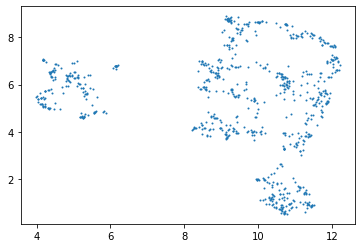

In [21]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=1, cmap='Spectral');
plt.savefig('umap.png', dpi=500)

# 4. Clustering with HDBSCAN

In [22]:
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [23]:
labels = hdbscan.HDBSCAN(
    min_samples=3,
    min_cluster_size=25,
).fit_predict(clusterable_embedding)

Numero di cluster: 11
Numero di punti non assegnati a nessun cluster: 28


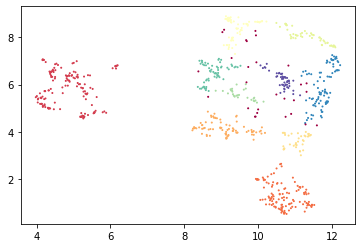

In [24]:
df['cluster']=pd.Series(labels)
print('Numero di cluster: '+ str(len(df['cluster'].unique())))
print('Numero di punti non assegnati a nessun cluster: ' + str(len(df[df.cluster == -1])))

plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=labels, s=1, cmap='Spectral');

In [25]:
df['xSPECTER']=pd.Series(clusterable_embedding[:, 0])
df['ySPECTER']=pd.Series(clusterable_embedding[:, 1])

In [26]:
df

,ID prodotto,finalAbstract,parole chiave scelte dall'utente (concatenazione),Titolo,Anno di pubblicazione,Tutti gli autori/Curatori,contributors: Autori/curatori attualmente afferenti (elenco),rivista: denominazione,lang/conf,conf,lang,cluster,xSPECTER,ySPECTER
0,235,"We consider a Cournot oligopoly game, where fi...",ECONOMIA POLITICA,Oligopoly games with nonlinear demand and cost...,2006,"Naimzada, AK; Sbragia, L","NAIMZADA, AHMAD KABIR","CHAOS, SOLITONS AND FRACTALS","Detected(lang=en, confidence=1.0)",1.0,en,4,10.066568,8.651076
1,340,This paper investigates the investment behavio...,COMPORTAMENTO ECONOMICO; ECONOMIC BEHAVIOR; RA...,Investment decisions and the soft budget const...,2006,"Colombo, E; Stanca, LM","COLOMBO, EMILIO; STANCA, LUCA MATTEO",ECONOMICS OF TRANSITION,"Detected(lang=en, confidence=1.0)",1.0,en,8,11.843930,5.212234
2,423,In this paper we investigate heavy crude oil a...,APPLIED ECONOMETRICS; ECONOMETRIA APPLICATA; E...,Modeling and forecasting cointegrated relation...,2005,"Lanza, A; Manera, M; Giovannini, M","MANERA, MATTEO",ENERGY ECONOMICS,"Detected(lang=en, confidence=1.0)",1.0,en,8,12.128462,7.105313
3,538,We propose an oligopoly game where quantity se...,ECONOMIA POLITICA,Oligopoly games with local monopolistic approx...,2007,"Bischi, GI; Naimzada, AK; Sbragia, L","NAIMZADA, AHMAD KABIR",JOURNAL OF ECONOMIC BEHAVIOR & ORGANIZATION,"Detected(lang=en, confidence=1.0)",1.0,en,4,9.505329,8.230165
4,611,This paper re-examines the issue of asymmetrie...,APPLIED ECONOMETRICS; ECONOMETRIA APPLICATA; E...,Rockets and feathers revisited: an internation...,2003,"Galeotti, M; Lanza, A; Manera, M","MANERA, MATTEO",ENERGY ECONOMICS,"Detected(lang=en, confidence=1.0)",1.0,en,5,11.951893,7.637979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,272697,We prove two results on the generic determinac...,TEORIE DEL VOTO; TEORIA DEI GIOCHI; POLITICAL ...,"On stable outcomes of approval, plurality, and...",2015,"De SInopoli, F; Iannantuoni, G; Pimienta, G","Iannantuoni, G",SOCIAL CHOICE AND WELFARE,"Detected(lang=en, confidence=1)",1.0,en,7,8.675111,6.692535
757,272700,We consider a model where policy motivated cit...,TEORIE DEL VOTO; TEORIA DEI GIOCHI; POLITICAL ...,Moderating Government,2015,"De Sinopoli, F; Ferraris, L; Iannantuoni, G","Iannantuoni, G",SOCIAL CHOICE AND WELFARE,"Detected(lang=en, confidence=1)",1.0,en,7,8.929616,6.366613
758,272840,This article addresses the issue of building r...,CAMPIONAMENTO; STATISTICA,Robustness against outliers: A new variance in...,2019,"Di Brisco, A; Migliorati, S; Ongaro, A","Di Brisco, AM; Migliorati, S; Ongaro, A",STATISTICAL MODELLING,"Detected(lang=en, confidence=1)",1.0,en,0,5.037622,6.263376
759,273076,Radon is a noble gas that occurs in nature as ...,STATISTICA; STATISTICS,Analysing radon accumulation in the home by fl...,2019,"Borgoni, R; Carcagnì, A; Salvati, N; Schmid, T","Borgoni, R; Carcagnì, A",STOCHASTIC ENVIRONMENTAL RESEARCH AND RISK ASS...,"Detected(lang=en, confidence=1)",1.0,en,0,4.169441,5.060941


In [27]:
df = df[['ID prodotto','finalAbstract',"parole chiave scelte dall'utente (concatenazione)", 'Titolo','Anno di pubblicazione','Tutti gli autori/Curatori','rivista: denominazione','cluster','xSPECTER','ySPECTER']]

In [28]:
df.to_csv('SPECTERFinale.csv', encoding='utf-8-sig')